In [1]:
# 라이브러리 및 모듈 import
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import pandas as pd
import cv2
import os
import torch
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from tqdm.notebook import tqdm
import json

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.patches as patches
from collections import Counter

sns.set_style("darkgrid")

In [2]:
annotation = '../../dataset/train.json'
data_dir = '../../dataset'

In [3]:
# coco = COCO(annotation)
# predictions = {
#             "images": coco.dataset["images"].copy(),
#             "categories": coco.dataset["categories"].copy(),
#             "annotations": None
#         }

In [25]:
with open(annotation) as json_file:
    anns = json.load(json_file)

print(anns.keys())
# print(json.dumps(anns['info'], indent=4))
# print(json.dumps(anns['licenses'], indent=4))
# print(json.dumps(anns['images'], indent=4))
# print(json.dumps(anns['categories'], indent=4))
# print(json.dumps(anns['annotations'][0], indent=4))
print()

label_name = [ann_dict['name'] for ann_dict in anns['categories']]
print(label_name)

df = pd.json_normalize(anns['annotations'])
df[["X","Y","W","H"]] = list(df.bbox)
df.drop(columns='bbox', inplace=True)
df['WH_ratio'] = df['W']/df['H']
df['HW_ratio'] = df['H']/df['W']
df['sqrt_area'] = np.sqrt(df['area'])
df['category_name'] = df['category_id'].apply(lambda x: label_name[x])
df = df[['id', 'image_id', 'category_id', 'category_name', 'area', 'sqrt_area', 'WH_ratio', 'HW_ratio', 'X', 'Y', 'W', 'H', 'iscrowd']]
if len(df['iscrowd'].unique()) == 1:
    df.drop(columns='iscrowd', inplace=True)
print(df.columns)
df.sample(10)


dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])

['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
Index(['id', 'image_id', 'category_id', 'category_name', 'area', 'sqrt_area',
       'WH_ratio', 'HW_ratio', 'X', 'Y', 'W', 'H'],
      dtype='object')


,id,image_id,category_id,category_name,area,sqrt_area,WH_ratio,HW_ratio,X,Y,W,H
16698,16698,3516,0,General trash,12244.21,110.653558,1.621404,0.616749,0.0,595.6,140.9,86.9
1568,1568,306,0,General trash,23946.48,154.746502,1.184248,0.844418,266.0,376.6,168.4,142.2
12383,12383,2616,1,Paper,16348.80,127.862426,0.563711,1.773958,927.7,545.2,96.0,170.3
6527,6527,1372,7,Plastic bag,32067.90,179.075124,0.803303,1.244860,460.2,362.7,160.5,199.8
686,686,138,2,Paper pack,12060.38,109.819761,1.102294,0.907199,118.1,544.2,115.3,104.6
13478,13478,2872,1,Paper,64691.33,254.344904,0.415252,2.408176,615.6,316.2,163.9,394.7
5562,5562,1159,5,Plastic,77365.78,278.147047,0.859047,1.164081,523.8,209.8,257.8,300.1
13042,13042,2764,0,General trash,64959.39,254.871320,1.065614,0.938426,150.3,365.0,263.1,246.9
19980,19980,4219,4,Glass,59313.00,243.542604,1.096303,0.912157,237.0,791.1,255.0,232.6
11448,11448,2421,5,Plastic,17109.33,130.802638,0.365696,2.734513,419.8,460.5,79.1,216.3


In [26]:
df.describe().round(2)

,id,image_id,category_id,area,sqrt_area,WH_ratio,HW_ratio,X,Y,W,H
count,23144.00,23144.00,23144.00,23144.00,23144.00,23144.00,23144.00,23144.00,23144.00,23144.00,23144.00
mean,11571.50,2439.38,3.41,92863.96,244.44,1.30,1.21,386.20,382.23,257.50,252.24
std,6681.24,1410.66,2.83,135979.15,181.97,1.17,0.99,244.49,217.28,204.58,200.14
min,0.00,0.00,0.00,0.56,0.75,0.06,0.04,0.00,0.00,0.70,0.80
25%,5785.75,1206.00,1.00,9997.67,99.99,0.69,0.65,200.10,226.98,99.75,93.50
50%,11571.50,2453.50,3.00,38938.47,197.33,1.05,0.95,362.70,370.50,200.90,196.10
75%,17357.25,3678.00,7.00,119122.48,345.14,1.54,1.45,553.32,524.90,357.65,359.82
max,23143.00,4882.00,9.00,1048371.21,1023.90,27.29,18.05,1015.40,1011.50,1023.90,1023.90


In [23]:
df['category_id'].value_counts().sort_values()

Battery           159
Clothing          468
Paper pack        897
Metal             936
Glass             982
Styrofoam        1263
Plastic          2943
General trash    3966
Plastic bag      5178
Paper            6352
Name: category_id, dtype: int64

linear


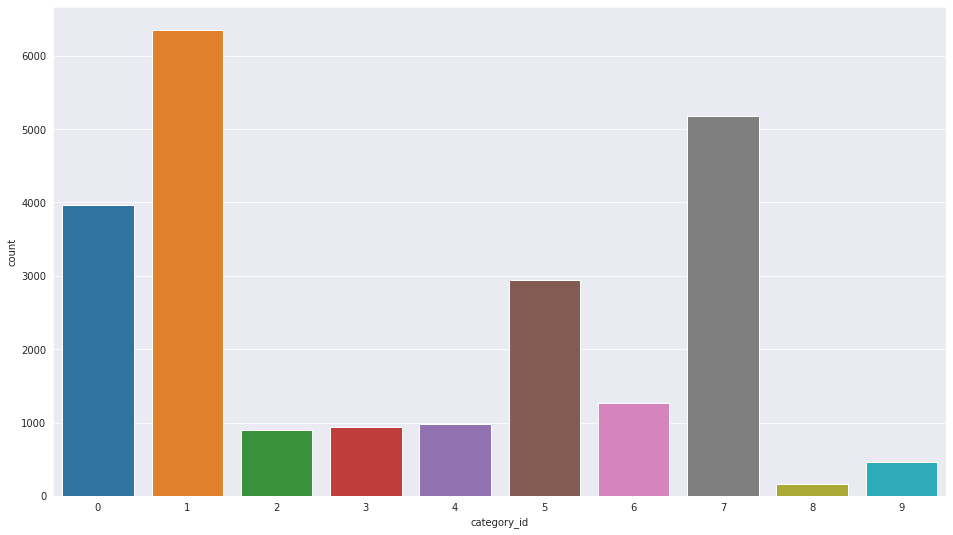

In [28]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.countplot(x='category_id', data=df, ax=ax)

for idx, val in df['category_id'].value_counts().sort_index().iteritems():
    axes[0].text(x=idx+0.05, y=val+3, s=val,
            va='bottom', ha='left',
            fontsize=10, fontweight='semibold'
           )

print(ax.get_yscale())
plt.show()

In [7]:
img_by = df[['image_id', 'category_id']].groupby(['image_id']).agg([pd.Series.count, pd.Series.nunique])
img_by.columns = list(map(lambda x: 'cat_' + x[1],img_by.columns))
img_by.sample(10)

,cat_count,cat_nunique
image_id,,
3933,1,1
95,1,1
1532,1,1
2316,2,1
54,8,3
835,1,1
153,1,1
212,1,1
1183,1,1


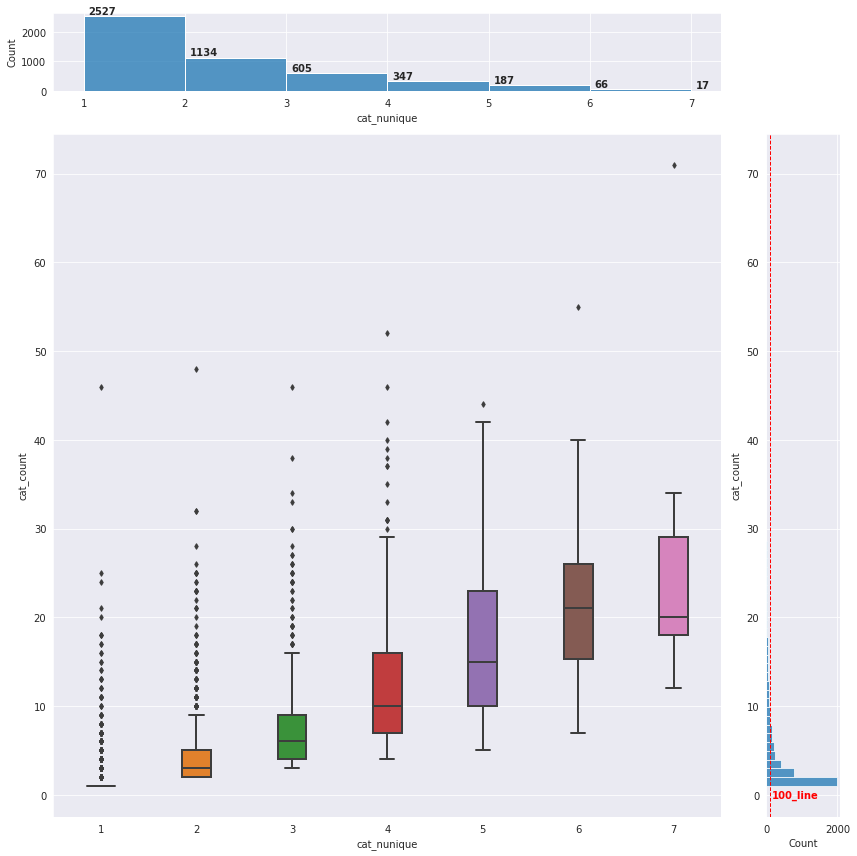

In [13]:
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(7, 7) # make 3 by 3 grid (row, col)
axes = [None for _ in range(3)]

axes[0] = fig.add_subplot(gs[0, :6])
axes[1] = fig.add_subplot(gs[1:, :6])
axes[2] = fig.add_subplot(gs[1:, 6])

sns.boxplot(x='cat_nunique', y='cat_count', data=img_by, width=0.3, linewidth=2, fliersize=4, ax=axes[1])

sns.histplot(x='cat_nunique', data=img_by, bins=6, ax=axes[0])
# axes[0].spines[['top', 'bottom', 'right']].set_visible(False)
# axes[0].xaxis.set_visible(False)
# axes[0].grid()
for idx, val in img_by['cat_nunique'].value_counts().sort_index().iteritems():
    axes[0].text(x=idx+0.05, y=val+3, s=val,
            va='bottom', ha='left',
            fontsize=10, fontweight='semibold'
           )

sns.histplot(y='cat_count', data=img_by, bins=71, ax=axes[2])
# axes[2].spines[['top', 'right', 'left']].set_visible(False)
# axes[2].yaxis.set_visible(False)
# axes[2].grid()
axes[2].axvline(x=100, color='r', linestyle='--', linewidth=1)
axes[2].text(x=150, y=0.5, s='100_line', color='r',
            va='top', ha='left',
            fontsize=10, fontweight='semibold'
           )

plt.tight_layout()
plt.show()

In [9]:
cat_by = df[['category_id', 'sqrt_area', 'WH_ratio']].groupby(['category_id']).agg(pd.Series.mean)
cat_by.sample(10)

,sqrt_area,WH_ratio
category_id,,
Glass,221.612457,1.043987
Battery,204.938078,1.428327
Styrofoam,264.023260,1.474087
Clothing,375.942004,1.228279
Plastic,224.774716,1.288092
Metal,245.298546,1.239462
Plastic bag,278.686894,1.106761
Paper pack,227.088297,1.296333
General trash,209.775780,1.433186


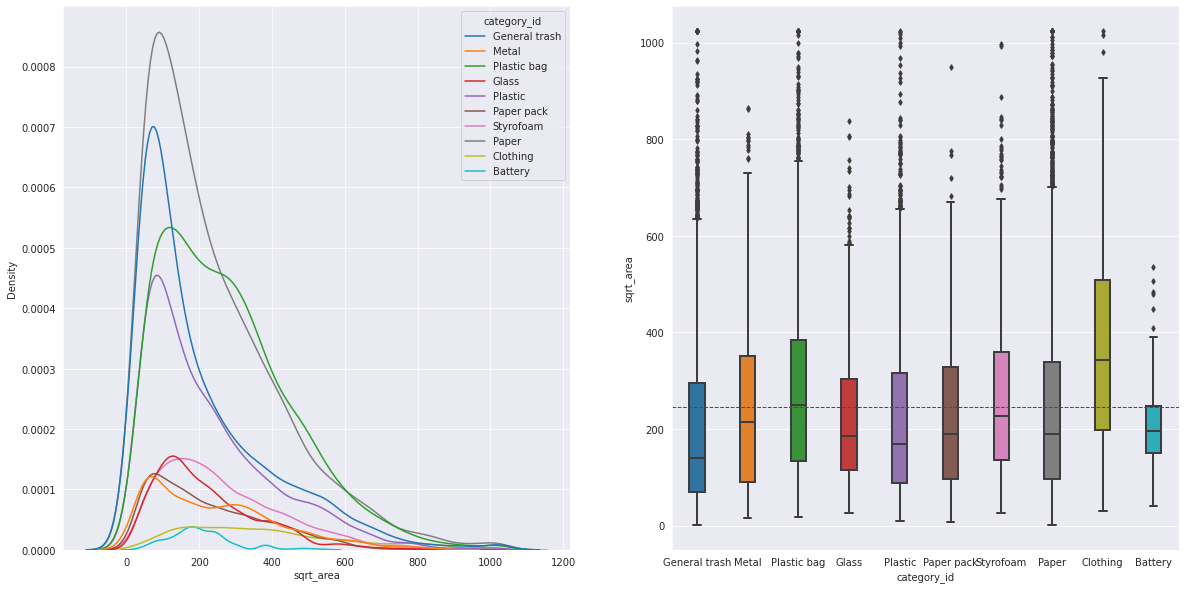

In [10]:
fig, axes = plt.subplots(1,2, figsize=(20, 10))
sns.kdeplot(x='sqrt_area', hue='category_id', data=df, bw_method=0.2, ax=axes[0])
# sns.histplot(x='sqrt_area', hue='category_id' ,data=df, ax=axes[0])
sns.boxplot(x='category_id', y='sqrt_area', data=df, width=0.3, linewidth=2, fliersize=4, ax=axes[1])
axes[1].axhline(y=df['sqrt_area'].mean(), color='r', linestyle='--', linewidth=1)
plt.show()

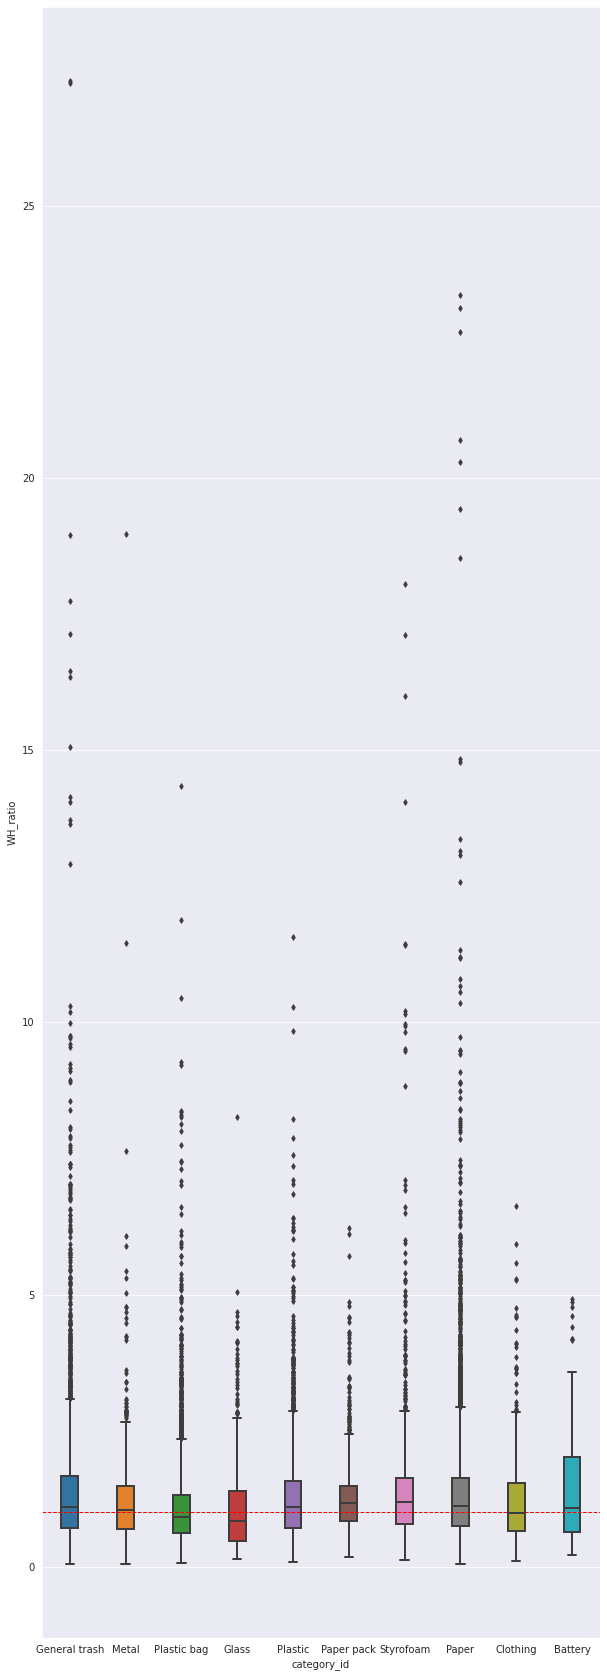

In [11]:
fig, ax = plt.subplots(figsize=(10, 30))
sns.boxplot(x='category_id', y='WH_ratio', data=df, width=0.3, linewidth=2, fliersize=4, ax=ax)
plt.axhline(y=1, color='r', linestyle='--', linewidth=1)
plt.show()

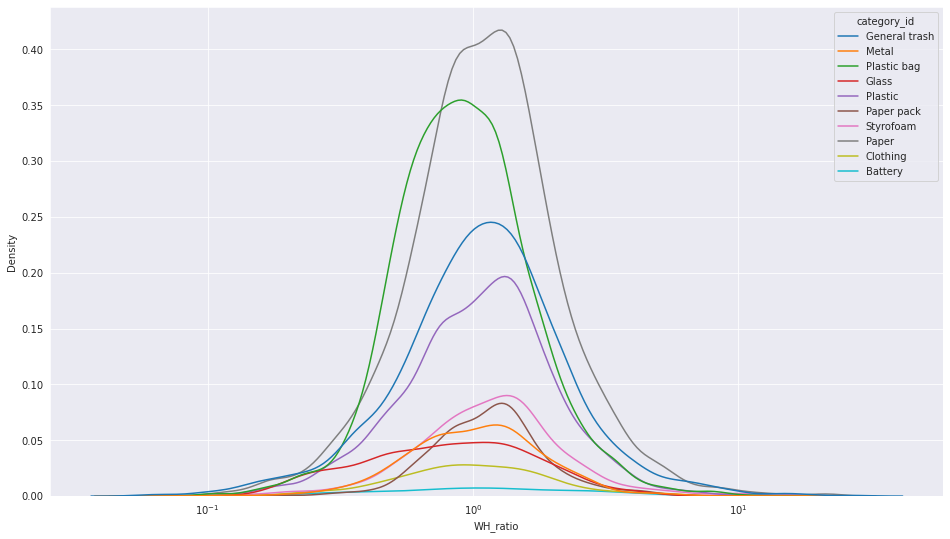

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.kdeplot(x='WH_ratio', hue='category_id', data=df, ax=ax, log_scale=True)
plt.show()